In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

# Getting Started
Let's walk through an example application of Geometricus in machine learning using a dataset of
human MAP kinases, divided into three classes - JNK, Erk, and p38 kinases. This dataset was generated from the [Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS)](https://klifs.vu-compmedchem.nl/index.php) (Raw table [here](../../example_data/MAPK_KLIFS.tsv)).

In [3]:
import pandas as pnd
from pathlib import Path
from time import time

url = "https://raw.githubusercontent.com/TurtleTools/geometricus/master/example_data/MAPK_KLIFS.tsv"
mapk_df = pnd.read_csv(url, sep="\t")

mapk_pdb_id_to_class = {}
for pdb_id, chain, class_name in list(zip(mapk_df["PDB"], mapk_df["CHAIN"], mapk_df["CLASS"])):
    mapk_pdb_id_to_class[(pdb_id, chain)] = class_name
len(mapk_pdb_id_to_class)

527

So now we have a list of (PDB ID, chain) pairs, each associated with a class

In [4]:
X_names = list(mapk_pdb_id_to_class.keys())
class_mapping = {"JNK": 0, "Erk": 1, "p38": 2}
y = [class_mapping[mapk_pdb_id_to_class[k]] for k in X_names]

## Structural fragmentation
We consider two different ways of dividing a protein with $l$ residues into structural fragments, a $k$-mer-based approach and a radius-based approach. For each structural fragment, four rotation and translation-invariant moments are calculated, termed $O_1, O_2, O_3$, and $O_4$. While the $k$-mer based approach is effective in describing structural fragments that are sequential in nature, such as $\alpha$-helices and loops, the radius-based approach can capture long-range structural contacts as seen in $\beta$-sheets, as well as distinct interaction patterns in space, as found in enzyme active sites.

Below we fetch and parse each protein as a ProDy AtomGroup object. This takes a while (around 15 mins) since it downloads via FTP from RCSB. 

In [5]:
import prody as pd

start_time = time()
pdbs = []
for i, (pdb_id, chain) in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins fetched in {(time() - start_time):.2f} seconds")
    pdbs.append(pd.parsePDB(pdb_id, chain=chain))

50 proteins fetched in 96.46 seconds
100 proteins fetched in 194.62 seconds
150 proteins fetched in 281.02 seconds
200 proteins fetched in 365.41 seconds
250 proteins fetched in 448.01 seconds
300 proteins fetched in 534.71 seconds
350 proteins fetched in 613.16 seconds
400 proteins fetched in 692.71 seconds
450 proteins fetched in 777.41 seconds
500 proteins fetched in 861.82 seconds


Moment invariants can be calculated using the `geometricus.MomentInvariants` class. This class has many constructors, such as the `from_prody_atomgroup` below. This can be replaced by `from_pdb_file` to load a protein from a file or even `from_pdb_id` to download from RCSB via FTP.

This is the point where you decide the type and size of structural fragmentation to use. The options are:

* KMER - each residue is taken as the center of a kmer of length `split_size`, ends are included but shorter
* RADIUS - overlapping spheres of radius `split_size`
* RADIUS_UPSAMPLE - upsamples backbone atoms before taking overlapping spheres.
* KMER_CUT - same as kmer but ends are not included, only fragments of length `split_size` are kept
* ALLMER - adds kmers of different lengths (`split_size - 5` to `split_size + 5`) to take into account deletions/insertions that don't change the shape

Below we use `SplitType.KMER` with a `split_size` (i.e. kmer size) of 16 and `SplitType.RADIUS` with a `split_size` (i.e. radius) of 10.

In [24]:
from geometricus import MomentInvariants, SplitType

invariants_kmer = []
invariants_radius = []

start_time = time()
for i, key in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins in {(time() - start_time):.2f} seconds")
    invariants_kmer.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.KMER, split_size=16))
    invariants_radius.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.RADIUS, split_size=10))

50 proteins in 3.42 seconds
100 proteins in 8.67 seconds
150 proteins in 15.67 seconds
200 proteins in 20.08 seconds
250 proteins in 25.12 seconds
300 proteins in 29.88 seconds
350 proteins in 33.77 seconds
400 proteins in 38.55 seconds
450 proteins in 43.29 seconds
500 proteins in 45.82 seconds


## Generating an Embedding from Structural Fragments
Moment invariants are discretized into shape-mers, using a **resolution** parameter which controls how coarse or fine-grained this discretization is. A count vector of shape-mers is calculated for each protein with each element recording the number of times the corresponding shape-mer appears in that protein. The resolution parameter can be optimized to the task at hand. Generally, more divergent proteins would require a lower resolution while highly similar proteins would need higher resolutions to differentiate them. For the MAP kinases, we use a relatively high resolution of 2.

Depending on the use-case you may want to embed all proteins at once, as demonstrated below, or separate train and test proteins as demonstrated in the Supervised Learning section.

### Embedding for Dimensionality Reduction
Embeddings across all proteins can be used for dimensionality reduction and visualization.

Generated embeddings in 1.19 seconds


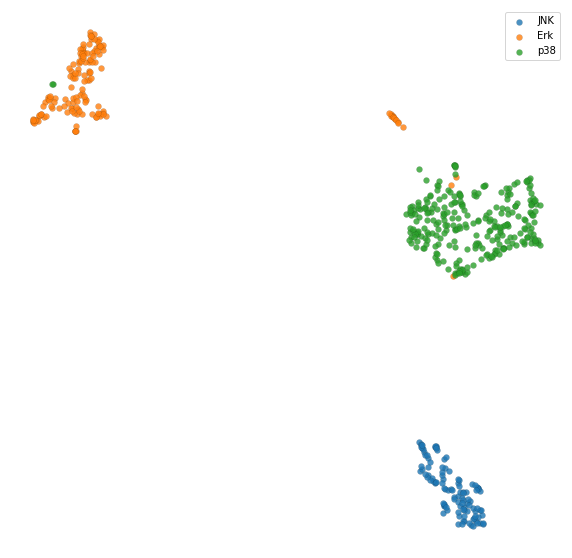

In [25]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from geometricus import GeometricusEmbedding

start_time = time()
kmer_embedder = GeometricusEmbedding.from_invariants(invariants_kmer, resolution=2.)
radius_embedder = GeometricusEmbedding.from_invariants(invariants_radius, resolution=2.)
print(f"Generated embeddings in {(time() - start_time):.2f} seconds")

reducer = umap.UMAP(metric="cosine", n_components=2)
reduced = reducer.fit_transform(np.hstack((kmer_embedder.embedding, radius_embedder.embedding)))

class_names = ["JNK", "Erk", "p38"]
colors = ["red", "green", "blue"]
plt.figure(figsize=(10,10))
for i in range(3):
    indices = np.where(np.array(y) == i)[0]
    plt.scatter(reduced[indices, 0],
                reduced[indices, 1],
                label=class_names[i], edgecolor="black", linewidth=0.1, alpha=0.8)
plt.axis("off")
plt.legend();

### Embedding for Supervised Learning
Supervised learning, be it classification or regression, requires some form of training and test set separation.
Below, the shape-mers used for embedding are calculated from the training set (using the kmer approach) and only those shape-mers are counted in the test proteins.

In [26]:
from sklearn.model_selection import train_test_split

X_train_names, X_test_names, y_train, y_test = train_test_split(X_names, y, test_size=0.3)

train_embedder = GeometricusEmbedding.from_invariants(invariants_kmer, resolution=2., protein_keys=X_train_names)
test_embedder = train_embedder.embed(invariants_kmer, X_test_names)

X_train, X_test = train_embedder.embedding, test_embedder.embedding

For this simple problem, a decision tree classifier is more than enough to obtain good accuracy.

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, [0, 1, 2], class_names))

              precision    recall  f1-score   support

         JNK       0.84      0.93      0.89        29
         Erk       0.93      0.89      0.91        46
         p38       0.95      0.94      0.95        84

    accuracy                           0.92       159
   macro avg       0.91      0.92      0.91       159
weighted avg       0.93      0.92      0.92       159



## Finding predictive residues and structural fragments

Since each shape-mer can be mapped back to the residues it describes, it's easy to use Geometricus to determine predictive or functionally relevant residues and structural regions from a trained predictor (or from loadings generated from a method such as PCA). Such insights can be directly be applied to select candidate residues for mutational studies or used in directed evolution techniques to engineer proteins and enzymes with desired properties.

By inspecting the decision tree created above, it becomes clear that some shape-mers are present multiple times across a protein and the number of times differs across classes.

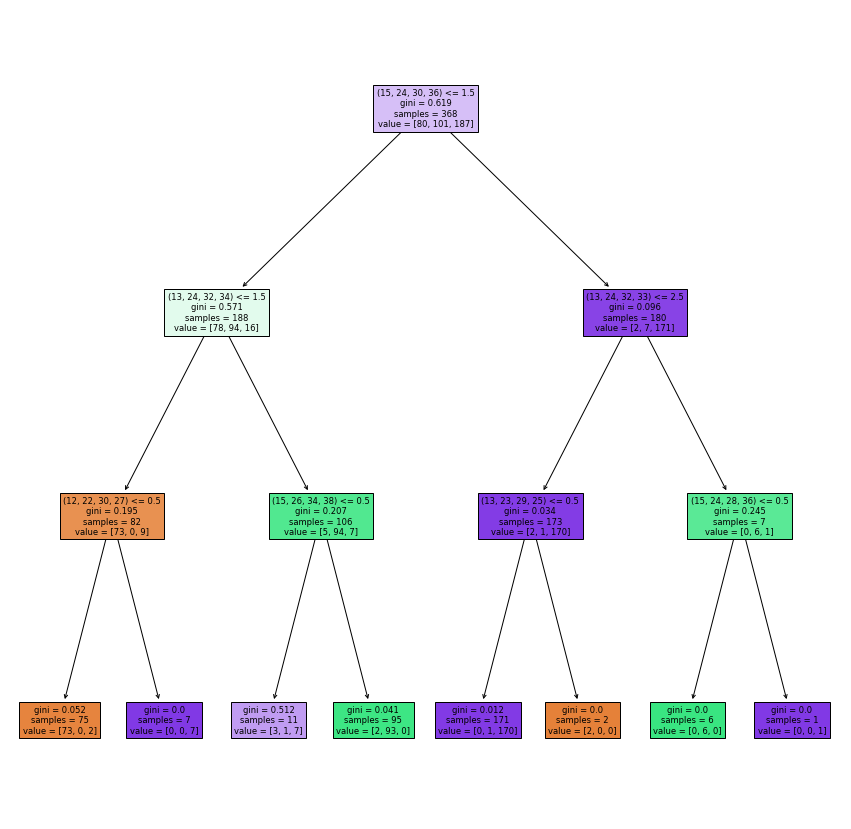

In [28]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(1, figsize=(15,15))
plot_tree(clf, filled=True, ax=ax, feature_names=train_embedder.shapemer_keys);

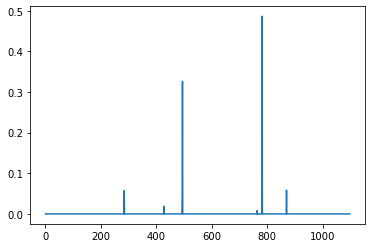

In [29]:
plt.plot(clf.feature_importances_)
predictive_feature_indices = np.argsort(clf.feature_importances_)[::-1][:6]

We can map back to the residues described by a shape-mer using the `map_shapemer_to_residues` function which returns a dictionary mapping each protein to the corresponding residue indices of the shape-mer within that protein, if it exists.

In [30]:
shapemer = train_embedder.shapemer_keys[predictive_feature_indices[1]]
residue_indices_train = train_embedder.map_shapemer_to_residues(shapemer)
print("Shape-mer:", shapemer, "Number of proteins with shape-mer:", len(residue_indices_train))
print()
print("Residue indices per protein (for 10 proteins):")
for i, key in enumerate(residue_indices_train):
    if i > 10:
        break
    print(key, residue_indices_train[key])

Shape-mer: (13, 24, 32, 34) Number of proteins with shape-mer: 507

Residue indices per protein (for 10 proteins):
('3o2m', 'A') {234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
('3o2m', 'B') {234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
('4eh8', 'A') {231, 232, 233, 234, 235, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119}
('4eh2', 'A') {230, 231, 232, 233, 234, 235, 236, 221, 222, 223, 224, 225, 226, 227, 228, 229, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119}
('4eh7', 'A') {224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 221, 222, 223}
('4eh5', 'A') {224, 225, 226, 227, 228, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223}
('4dli', 'A') {224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 218, 219, 220, 221, 222, 223}
('4eh3', 'A') {231, 232, 233, 234, 235, 236, 

These residue indices can then be visualized on a protein structure using molecule visualization software such as PyMol. Comparing the same location in proteins which don't have this shape-mer can also be informative.